# Final Deliverables 
● Video: a 10 minute YouTube video explaining your project / the key pieces of code / experiments you ran / and results. Should contain slides + code walkthrough.
● Complete code: either a Jupyter notebook that runs end-to-end on Colab, or a zip including source, a README, and a shell script to run it. Please include a saved model as well.

# Code

● Train a model using a subset of the training data from CAMELYON16.

● Include a script to run it on a testing image and generate a heatmap (note:
you do not need to create a 100,000 x 100,000 heatmap -- use a much lower
resolution).

# Results
● Design a thoughtful evaluation method, and include the results on at least
three images from the testing set.

● Include a saved, trained version of your model with your submission.

# Tips

●  “We surprisingly found that slimmed-down Inception architectures with only 3% of the parameters achieved similar performance to the full version”

● Authors found that using a pretrained model on ImageNet ultimately hurt accuracy (Why? Pathology images do not match the natural images from ImageNet) -- but -- it improved convergence speed. This is a good place to start. Try transfer learning
and/or fine-tuning.

● Start with a low zoom level (much smaller images), a simple model, and a small amount of data.

● Implement an end-to-end prototype (training data in -> heatmap on a test image out), then slowly scale up.

● Begin with transfer learning from a model trained on ImageNet, then fine-tuning, then consider training a model from scratch. Only after this is working end-to-end, consider data augmentation, using higher zooms,
etc.

#### install packages, mount gdrive, create directory

In [1]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 11 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 1s (172 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 130812 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [5]:
import os
import pandas as pd

MY_DRIVE_DIR = '/content/gdrive/My Drive'
SLIDES_DIR = os.path.join(MY_DRIVE_DIR, 'Deep Learning class/slides') # changing the path for readibility used to be #slide_data

print(MY_DRIVE_DIR)
print(os.path.exists(MY_DRIVE_DIR))
print(SLIDES_DIR)
print(os.path.exists(SLIDES_DIR))

/content/gdrive/My Drive
True
/content/gdrive/My Drive/Deep Learning class/slides
True


#### Functions

In [0]:
# Download an example slide and tumor mask

# Important note: the remainder are in a Google Drive folder, linked above.
# You will need to host them on your own, either in Google Drive, or by using
# the cloud provider of your choice.

def choose_image(image_number):
  
  global slide_path
  global tumor_mask_path
  global slide
  global tumor_mask
  
  slide_path = os.path.join(SLIDES_DIR, 'tumor_'+image_number+'.tif')
  tumor_mask_path =  os.path.join(SLIDES_DIR, 'tumor_'+image_number+'_mask.tif')
  
  slide = open_slide(slide_path)
  print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                          slide.level_dimensions[0][0], 
                                                          slide.level_dimensions[0][1]))

  tumor_mask = open_slide(tumor_mask_path)
  print ("Read tumor mask from %s" % (tumor_mask_path))

  print("Slide includes %d levels", len(slide.level_dimensions))

  for i in range(len(slide.level_dimensions)-1):
      x = slide.level_dimensions[i][0]
      y = slide.level_dimensions[i][1]
      
      print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                               slide.level_dimensions[i], 
                                                               slide.level_downsamples[i]))
      assert tumor_mask.level_dimensions[i][0] == x
      assert tumor_mask.level_dimensions[i][1] == y

      downsample = 2**i
      dim = 299.
      
      dat.append({'image': image_number, 'level': i, 'downsample factor': downsample, 'x': x, 'y': y, \
                    'max windows': int(round((x*y)/dim**2,0)-1)})
      #Dict[temp] = (float(slide.level_dimensions[i][0]), float(slide.level_dimensions[i][1]))

  # Verify downsampling works as expected
  width, height = slide.level_dimensions[7]
  assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
  assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]
  
  return slide_path, tumor_mask_path

In [0]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array

def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [0]:
def zoom(i): 
  
  slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=i, 
                         width=slide.level_dimensions[i][0], 
                         height=slide.level_dimensions[i][1])
     

  # Example: read the entire mask at the same zoom level
  mask_image = read_slide(tumor_mask, 
                       x=0, 
                       y=0, 
                       level=i, 
                       width=tumor_mask.level_dimensions[i][0], 
                       height=tumor_mask.level_dimensions[i][1])

  # Note: the program provided by the dataset authors generates a mask with R,G,B channels.
  # The mask info we need is in the first channel only.
  # If you skip this step, the mask will be displayed as all black.
  mask_image = mask_image[:,:,0]

  return slide_image, mask_image

In [0]:
def show_slide():
  
  plt.figure('slide', figsize=(10,10), dpi=100)
  plt.imshow(slide_image)
  
  return 'slide image'

In [0]:
def show_mask():

  plt.figure('mask', figsize=(10,10), dpi=100)
  plt.imshow(mask_image, cmap='binary')
  
  return 'mask'

In [0]:
def show_overlay(a):
  
  plt.figure(figsize=(10,10), dpi=100)
  plt.imshow(slide_image)
  plt.imshow(mask_image, cmap = 'OrRd', alpha = a)
  
  return 'overlay'

In [0]:
# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.

def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return zip(indices[0], indices[1])

In [0]:
def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

#### Workflow with image 031

In [159]:
downsample = None
dat = []

choose_image('031')

Read WSI from /content/gdrive/My Drive/Deep Learning class/slides/tumor_031.tif with width: 97792, height: 221184
Read tumor mask from /content/gdrive/My Drive/Deep Learning class/slides/tumor_031_mask.tif
Slide includes %d levels 10
Level 0, dimensions: (97792, 221184) downsample factor 1
Level 1, dimensions: (48896, 110592) downsample factor 2
Level 2, dimensions: (24448, 55296) downsample factor 4
Level 3, dimensions: (12224, 27648) downsample factor 8
Level 4, dimensions: (6112, 13824) downsample factor 16
Level 5, dimensions: (3056, 6912) downsample factor 32
Level 6, dimensions: (1528, 3456) downsample factor 64
Level 7, dimensions: (764, 1728) downsample factor 128
Level 8, dimensions: (382, 864) downsample factor 256


('/content/gdrive/My Drive/Deep Learning class/slides/tumor_031.tif',
 '/content/gdrive/My Drive/Deep Learning class/slides/tumor_031_mask.tif')

Example: read the entire slide at level 5

Higher zoom levels may not fit into memory. You can use the below function to extract regions from higher zoom levels without having to read the entire image into ram.

Use the sliding window approach discussed in class to collect training data for your classifier. E.g., slide a window across the slide (for starters, use a zoomed in view, so you're not working with giant images). Save each window to disk as an image. To find the label for that image, check to the tissue mask to see if the same region contains cancerous cells.

Important: this is tricky to get right. Carefully debug your pipeline beforetraining your model. Start with just a single image, and a relatively low zoom level.

In [0]:
slide_image, mask_image = zoom(5)

In [270]:
# checking dimentions
slide_image.shape

(6912, 3056, 3)

In [271]:
# checking dimentions
mask_image.shape

(6912, 3056)

'slide image'

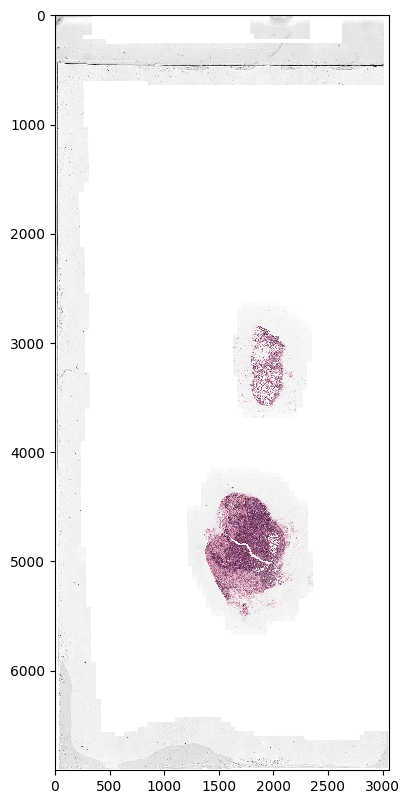

In [161]:
show_slide()

'mask'

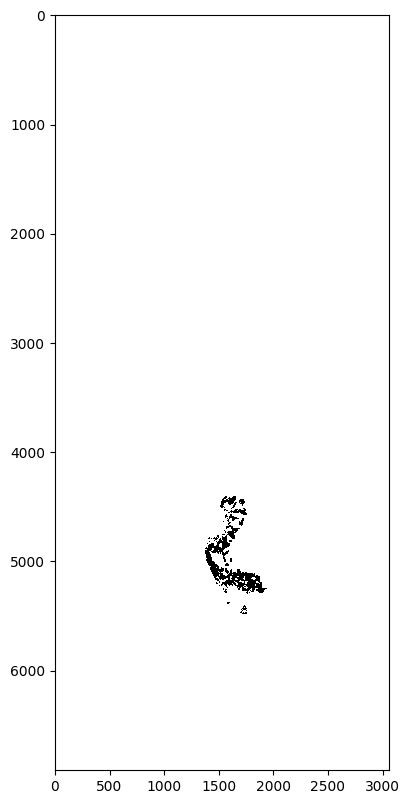

In [162]:
show_mask()

'overlay'

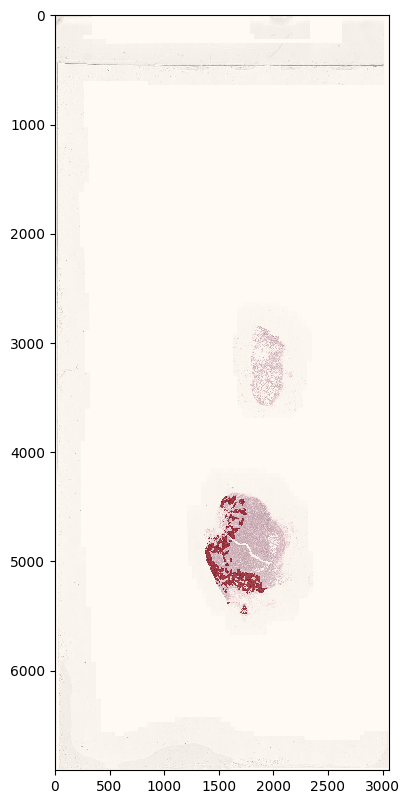

In [163]:
show_overlay(0.6)

In [164]:
df=pd.DataFrame(dat)
df

,downsample factor,image,level,max windows,x,y
0,1,031,0,241943,97792,221184
1,2,031,1,60485,48896,110592
2,4,031,2,15120,24448,55296
3,8,031,3,3779,12224,27648
4,16,031,4,944,6112,13824
5,32,031,5,235,3056,6912
6,64,031,6,58,1528,3456
7,128,031,7,14,764,1728
8,256,031,8,3,382,864


In [165]:
df['x'][5]

3056

In [166]:
#Note "actual dim" represents the dimensions on the slide image
actual_dim = float(df['x'][4])
downsample = float(df['x'][5])
correction = (downsample/actual_dim) * int(df['downsample factor'][5])
correction

16.0

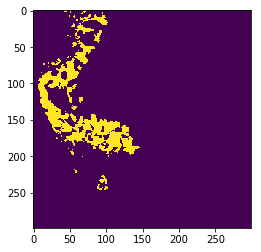

In [167]:
# Example: extract a (cancer) region from the L7 downsampled image
# Notice we're multiplying the x,y coordinates by the downsample factor.
# This math can be tricky to get right, debug carefully.
# Here, we're "aiming" for the top right blob in the image above.

region = read_slide(tumor_mask, x=(2700*16), y=(9000*16), level=7, width=299, height=299)[:,:,0]
plt.imshow(region)

In [168]:

tissue_pixels = list(find_tissue_pixels(slide_image))
percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[0]) * 100
print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 

718684 tissue_pixels pixels (1.5 percent of the image)


In [169]:
slide_image.shape

(6912, 3056, 3)

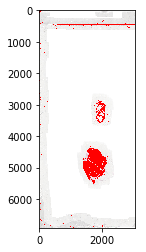

In [240]:
tissue_regions = apply_mask(slide_image, tissue_pixels)
plt.imshow(tissue_regions)

In [171]:
tissue_regions.shape

(6912, 3056, 3)

## The following is an mvp for creating training data from a single slide, at zoom level 5

In [0]:
# x dimensions from 0 to 500 are slide artifacts
#500./x_max
#y dimensions from 0 to ~1000 are slide artifacts
#1000./y_max

#### Create training data - sliding window pseudocode

for window in image:

	if window contains tissue:
		append window to train_set

		if window contains cancer:
			label = 1
		else:
			label = 0

In [0]:
def is_tissue_in_window(window, intensity=0.8):
  im_gray = rgb2gray(window)
  x_indices = np.where(im_gray <= intensity)[0]
  return len(x_indices) > 0

In [0]:
#MVP with zoom level 5
train = []
labels = []

#dimensions at level 5
x_max = slide.level_dimensions[5][0]
y_max = slide.level_dimensions[5][1]

#create padding to avoid silde edges.. empirically, 15% seemed reasonable
x0 = int(.15*x_max)
y0 = int(.15*y_max)

#size of window
x_dim, y_dim = 299., 299.
size = (int(x_dim), int(y_dim))

#level
L = int(5)

# calculate how many steps we can take with 299x299 window
x_steps, y_steps = int(((x_max-x0) / x_dim)-1), int(((y_max-y0) / y_dim)-1)

#from above, 'correction' factor for relating dimensions back to visual indications
#this correction factor is invariant for the zoom level, assuming we adjust x_max, y_max as defined above to specific level of interest
x0 = x0*16
y0 = y0*16
        
for i in range(x_steps):
  for j in range(y_steps):
    location = (int(x0), int(y0)) # just added
    
    # generating a window from the original slide
    window = slide.read_region(location, L, size) # we can just use read slide here instead
    window = window.convert('RGB')
    window = np.asarray(window)
    assert window.shape == (x_dim, y_dim, 3)
    
    #If window contains tissue, append to train
    if is_tissue_in_window(window) is False:
      continue # No tissue in this window, don't add to train or test                  
   
    train.append(window)
    
    # read the tumor mask view that corresponds to the window
    window_mask = tumor_mask.read_region(location, L, size)
    window_mask = window_mask.convert('RGB')
    window_mask = np.asarray(window_mask)
    window_mask = window_mask[:,:,0]
    
    #if window contains cancer, append 1 to labels; else 0
    if sum(window_mask.flatten()) > 1: # check with team if there is a better way to check pixels
        labels.append(1)
    else:
        labels.append(0)
    
    y0 += y_dim
    
  x0 += x_dim


In [153]:
# After adding filter for windows with tissue
print(len(train), x_steps * y_steps)

19 126


In [154]:
train[0].shape

(299, 299, 3)

In [265]:
# looking into the number of cancer labels generated
sum(labels) # there is a bug somewhere, this should not happen!

0

In [266]:
# checking labels length
len(labels)

94

In [0]:
#PLAYING TO FIX THE BUG
#MVP with zoom level 5
windows = []
masks = []
labels = []

#dimensions at level 5
x_max = tumor_mask.level_dimensions[5][0]
y_max = tumor_mask.level_dimensions[5][1]


#create padding to avoid silde edges.. empirically, 15% seemed reasonable
x0 = int(.15*x_max)
y0 = int(.15*y_max)

#size of window
x_dim, y_dim = 299., 299.
size = (int(x_dim), int(y_dim))

#level
L = int(5)

# calculate how many steps we can take with 299x299 window
x_steps, y_steps = int(((x_max-x0) / x_dim)-1), int(((y_max-y0) / y_dim)-1)

#from above, 'correction' factor for relating dimensions back to visual indications
#this correction factor is invariant for the zoom level, assuming we adjust x_max, y_max as defined above to specific level of interest
x0 = x0*16
y0 = y0*16
        
for i in range(x_steps):
  for j in range(y_steps):
    location = (int(x0), int(y0))
    
    # read the mask view that corresponds to the window
    window_mask = read_slide(tumor_mask, level=L, x=int(x0), y=int(y0), width=299, height = 299)
    window_mask = window_mask[:,:,0]
    masks.append(window_mask)
    
    #if window contains cancer, append 1 to labels; else 0
    if sum(window_mask.flatten()) > 1: # check with team if there is a better way to check pixels
        labels.append(1)
    else:
        labels.append(0)
    
    y0 += y_dim
    
  x0 += x_dim



In [247]:
sum(labels)

0

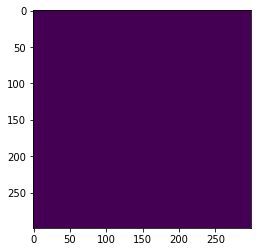

In [268]:
plt.imshow(masks[40])